<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-07 18:10:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-03-07 18:10:56 (13.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples.

A smaller number of samples is something you'll often run into  with time series data problems. 

> 🔑 **Note:** The **seasonality** of time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.



In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


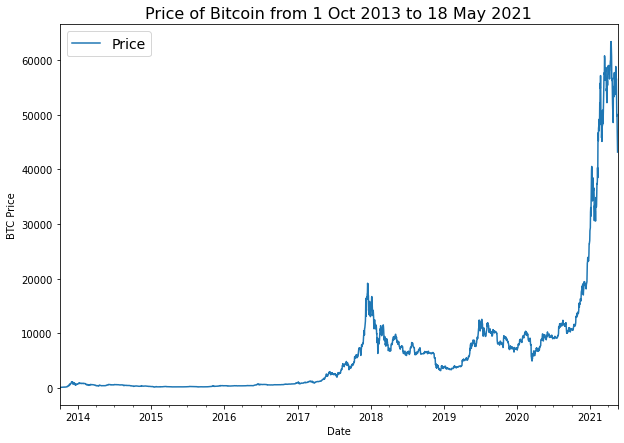

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

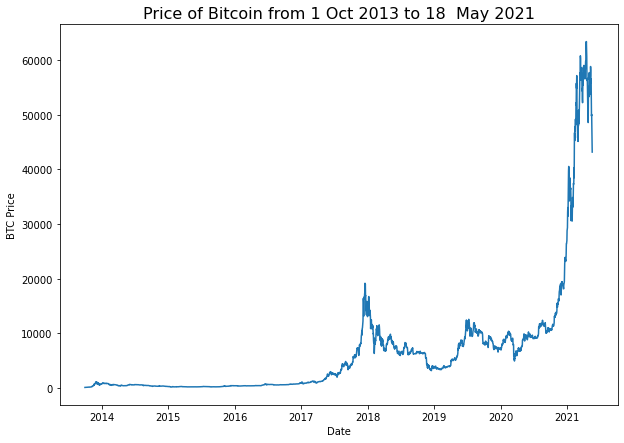

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,
         btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18  May 2021", fontsize=16)
plt.xlabel("Date");


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for timeseries data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

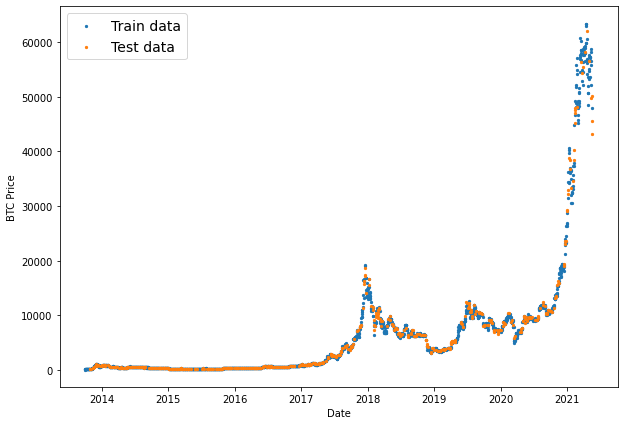

In [10]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)


In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

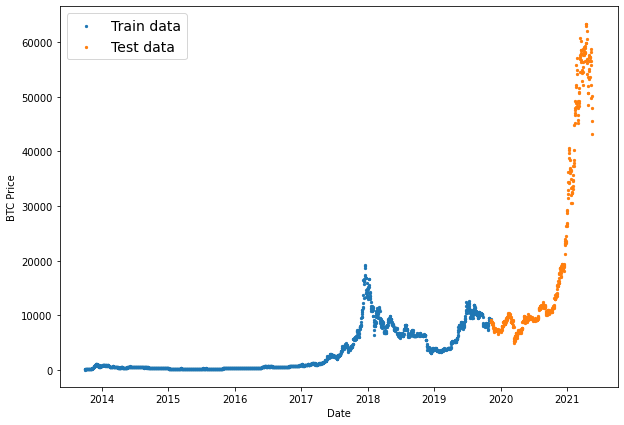

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

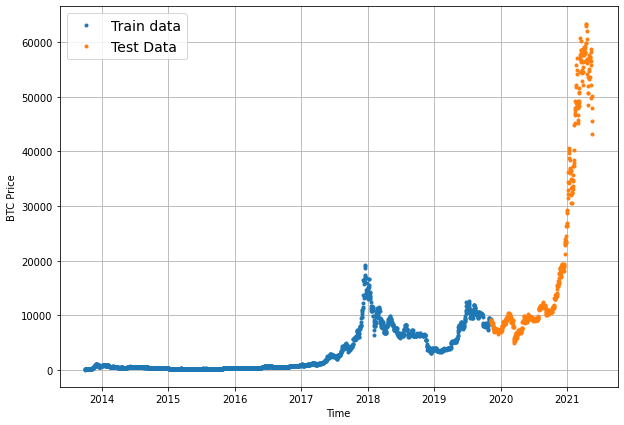

In [14]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

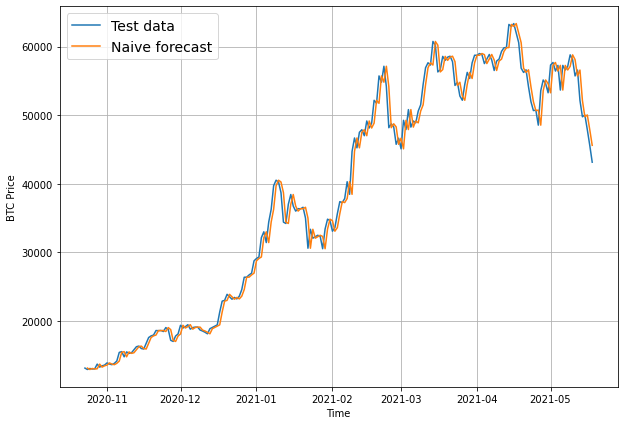

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> ⚒️ **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. An have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

from IPython.core.magic import error
## Evaluating a time series model

Let's take into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that mean we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RSME - root mean suare error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
+ MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
import tensorflow as tf

In [18]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error (MASE) between true and predicted values.

  The MASE measures the relative performance of a forecasting model compared to a naive (naïve2) forecast.
  The MASE is a scaling factor that scales the mean absolute error (MAE) of the forecast to account for the scale
  of the data and the forecast horizon. A MASE of 1 indicates that the forecasting model performs as well as a
  naive forecast, while a MASE < 1 indicates that the model outperforms the naive forecast.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A scalar value representing the MASE between y_true and y_pred.
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [20]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [22]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
len(y_train)

2229

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of Bitcoin data to make the prediction


In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
    Given a data matrix 'x', return a pair of matrices containing labelled and windowed segments of the data.

    Parameters:
        - x (ndarray): A 2-dimensional matrix of shape (T, D), where T is the number of timesteps and
          D is the number of dimensions.
        - horizon (int): The number of timesteps to include in the window.
        
    Returns:
        - A tuple containing two 2-dimensional matrices of shape (T - horizon, horizon) and (T - horizon, 1),
          respectively. The first matrix contains the windowed segments of the input data, and the second matrix
          contains the labels that correspond to each window.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 5, 6],
[1, 2, 3, 5, 6, 7],
[2, 3, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [30]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Creates windowed data from a target time series.

  Parameters:
      - x (ndarray): A 1-dimensional array containing the target time series.
      - window_size (int): The size of the window to use to create the data (default: WINDOW_SIZE).
      - horizon (int): The number of timesteps into the future to predict (default: HORIZON).

  Returns:
      - A tuple containing two 2-dimensional arrays of shape (N, window_size) and (N, horizon),
        respectively. The first array contains the windowed segments of the input data, and the
        second array contains the labels that correspond to each window.

  Example usage:
  ```python
  # Load some example data
  target_series = np.loadtxt('target_series.txt')

  # Create windowed data with a window size of 30 and a horizon of 1
  X, y = make_windows(target_series, window_size=30, horizon=1)
  ```
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D araay of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.

  Parameters:
       - windows (ndarray): A 2-dimensional matrix of shape (N, W), where N is the number of windows
        and W is the window size.
      - labels (ndarray): A 2-dimensional matrix of shape (N, H), where N is the number of windows
        and H is the horizon (i.e. the number of timesteps to predict into the future).
      - test_split (float): The proportion of data to allocate for the test split. Defaults to 0.2.

  Returns:
      - A tuple containing four 2-dimensional matrices: (train_windows, test_windows, train_labels, test_labels).
        The training windows and labels are the first two elements of the tuple and represent the training split of
        the input data, while the test windows and labels are the last two elements of the tuple and represent the
        test split of the input data.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [39]:
import os

# Create a function to implement a modelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  """
  Creates a Keras callback to save the best version of a trained model during training.

  Args:
      model_name (str): A string with the name of the model. This will be used as the prefix of the checkpoint file.
      save_path (str): A string with the directory path where the checkpoint file will be saved. Defaults to "model_experiments".

  Returns:
      A Keras `ModelCheckpoint` callback instance with the specified settings.
  """
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own


In [40]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 1:44 - loss: 2118.7527 - mae: 2118.7527 - mse: 9361085.0000

18/18 [==============================] - 7s 46ms/step - loss: 773.2059 - mae: 773.2059 - mse: 2293626.2500 - val_loss: 2171.8333 - val_mae: 2171.8333 - val_mse: 12092179.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 339.9844 - mae: 339.9844 - mse: 595374.5000

18/18 [==============================] - 0s 28ms/step - loss: 246.5126 - mae: 246.5126 - mse: 290093.9375 - val_loss: 1102.8845 - val_mae: 1102.8845 - val_mse: 4025640.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 145.5341 - mae: 145.5341 - mse: 79157.0234

18/18 [==============================] - 0s 28ms/step - loss: 194.0481 - mae: 194.0481 - mse: 186867.0000 - val_loss: 1022.3840 - val_mae: 1022.3840 - val_mse: 3462245.7500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 236.7855 - mae: 236.7855 - mse: 293819.3125

18/18 [==============================] - 0s 29ms/step - loss: 184.1312 - mae: 184.1312 - mse: 178563.6094 - val_loss: 987.9667 - val_mae: 987.9667 - val_mse: 3253950.5000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 179.0740 - mae: 179.0740 - mse: 171029.8594 - val_loss: 1010.1803 - val_mae: 1010.1803 - val_mse: 3198103.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 131.3586 - mae: 131.3586 - mse: 64215.9062

18/18 [==============================] - 0s 28ms/step - loss: 171.9874 - mae: 171.9874 - mse: 157206.5312 - val_loss: 951.2772 - val_mae: 951.2772 - val_mse: 3052141.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 207.3940 - mae: 207.3940 - mse: 296156.5938

18/18 [==============================] - 0s 28ms/step - loss: 165.2812 - mae: 165.2812 - mse: 147431.4062 - val_loss: 928.6701 - val_mae: 928.6701 - val_mse: 2799135.2500
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 159.3907 - mae: 159.3907 - mse: 139614.6875

18/18 [==============================] - 0s 29ms/step - loss: 159.6422 - mae: 159.6422 - mse: 138532.2656 - val_loss: 874.9318 - val_mae: 874.9318 - val_mse: 2560448.0000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 132.8242 - mae: 132.8242 - mse: 78791.7812

18/18 [==============================] - 0s 28ms/step - loss: 155.0317 - mae: 155.0317 - mse: 132434.6875 - val_loss: 863.8953 - val_mae: 863.8953 - val_mse: 2431854.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 161.5556 - mae: 161.5556 - mse: 178835.6875

18/18 [==============================] - 0s 28ms/step - loss: 150.3229 - mae: 150.3229 - mse: 126263.6719 - val_loss: 826.7307 - val_mae: 826.7307 - val_mse: 2257684.7500
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 142.7499 - mae: 142.7499 - mse: 114843.6484

18/18 [==============================] - 1s 29ms/step - loss: 144.0589 - mae: 144.0589 - mse: 115449.1094 - val_loss: 808.1310 - val_mae: 808.1310 - val_mse: 2136942.2500
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 141.2314 - mae: 141.2314 - mse: 111460.7266 - val_loss: 821.9568 - val_mae: 821.9568 - val_mse: 2108997.0000
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 139.2160 - mae: 139.2160 - mse: 108399.6953 - val_loss: 834.3863 - val_mae: 834.3863 - val_mse: 2099056.7500
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 136.7598 - mae: 136.7598 - mse: 103988.3438

18/18 [==============================] - 1s 29ms/step - loss: 136.7598 - mae: 136.7598 - mse: 103988.3438 - val_loss: 805.7483 - val_mae: 805.7483 - val_mse: 1985123.0000
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1364 - mae: 134.1364 - mse: 66979.7188

18/18 [==============================] - 1s 41ms/step - loss: 134.2693 - mae: 134.2693 - mse: 100573.7891 - val_loss: 743.1657 - val_mae: 743.1657 - val_mse: 1786755.2500
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 129.4372 - mae: 129.4372 - mse: 94967.0234 - val_loss: 758.5327 - val_mae: 758.5327 - val_mse: 1796762.8750
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 127.9302 - mae: 127.9302 - mse: 93105.0469 - val_loss: 750.2147 - val_mae: 750.2147 - val_mse: 1750855.8750
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 139.7020 - mae: 139.7020 - mse: 101369.2656

18/18 [==============================] - 0s 28ms/step - loss: 126.2300 - mae: 126.2300 - mse: 92299.5703 - val_loss: 714.8506 - val_mae: 714.8506 - val_mse: 1634484.1250
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 122.7586 - mae: 122.7586 - mse: 87893.2578 - val_loss: 727.7632 - val_mae: 727.7632 - val_mse: 1651913.3750
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7156 - mae: 121.7156 - mse: 85719.9375 - val_loss: 723.2875 - val_mae: 723.2875 - val_mse: 1751081.6250
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 127.5910 - mae: 127.5910 - mse: 91892.2578 

18/18 [==============================] - 0s 28ms/step - loss: 127.8778 - mae: 127.8778 - mse: 93588.6484 - val_loss: 682.8291 - val_mae: 682.8291 - val_mse: 1507854.2500
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 119.6049 - mae: 119.6049 - mse: 84610.8906 

18/18 [==============================] - 1s 29ms/step - loss: 119.1510 - mae: 119.1510 - mse: 84089.6172 - val_loss: 671.6611 - val_mae: 671.6611 - val_mse: 1471005.8750
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 120.5795 - mae: 120.5795 - mse: 83878.5391 - val_loss: 672.7620 - val_mae: 672.7620 - val_mse: 1467297.3750
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 126.9181 - mae: 126.9181 - mse: 75839.8203

18/18 [==============================] - 0s 27ms/step - loss: 118.3766 - mae: 118.3766 - mse: 82130.6016 - val_loss: 640.9272 - val_mae: 640.9272 - val_mse: 1405582.6250
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 118.1783 - mae: 118.1783 - mse: 81628.8359

18/18 [==============================] - 0s 29ms/step - loss: 117.7007 - mae: 117.7007 - mse: 80844.2812 - val_loss: 635.9830 - val_mae: 635.9830 - val_mse: 1391171.3750
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 117.7515 - mae: 117.7515 - mse: 77221.5469

18/18 [==============================] - 1s 39ms/step - loss: 118.1960 - mae: 118.1960 - mse: 80341.9844 - val_loss: 633.6140 - val_mae: 633.6140 - val_mse: 1387214.7500
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 118.3720 - mae: 118.3720 - mse: 81500.4375 

18/18 [==============================] - 1s 41ms/step - loss: 117.0021 - mae: 117.0021 - mse: 80092.7656 - val_loss: 628.8839 - val_mae: 628.8839 - val_mse: 1347892.8750
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 112.8097 - mae: 112.8097 - mse: 78883.1641

18/18 [==============================] - 1s 41ms/step - loss: 113.6640 - mae: 113.6640 - mse: 77956.3047 - val_loss: 622.2879 - val_mae: 622.2879 - val_mse: 1331012.0000
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 115.6659 - mae: 115.6659 - mse: 78280.8047

18/18 [==============================] - 1s 32ms/step - loss: 114.9841 - mae: 114.9841 - mse: 78213.5625 - val_loss: 618.0520 - val_mae: 618.0520 - val_mse: 1316361.5000
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 119.0378 - mae: 119.0378 - mse: 80267.5234 - val_loss: 638.0344 - val_mae: 638.0344 - val_mse: 1354980.5000
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9189 - mae: 113.9189 - mse: 75059.4297 - val_loss: 649.9708 - val_mae: 649.9708 - val_mse: 1378938.0000
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4569 - mae: 114.4569 - mse: 78498.3281 - val_loss: 641.3540 - val_mae: 641.3540 - val_mse: 1355560.5000
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0691 - mae: 113.0691 - mse: 74687.0547 - val_loss: 665.1609 - val_mae: 665.1609 - val_mse: 1408670.1250
Epoch 34/100
16/18 [=========================>....] - ETA: 0s - loss: 112.5145 - mae: 112.5145 - mse: 

18/18 [==============================] - 0s 29ms/step - loss: 112.5431 - mae: 112.5431 - mse: 77168.8047 - val_loss: 603.6063 - val_mae: 603.6063 - val_mse: 1270660.1250
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7074 - mae: 110.7074 - mse: 74807.0547 - val_loss: 606.5927 - val_mae: 606.5927 - val_mse: 1270212.5000
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0994 - mae: 115.0994 - mse: 76246.1953 - val_loss: 605.1116 - val_mae: 605.1116 - val_mse: 1264781.7500
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5793 - mae: 112.5793 - mse: 76441.8906 - val_loss: 608.5388 - val_mae: 608.5388 - val_mse: 1299988.0000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 109.9309 - mae: 109.9309 - mse: 71905.2969

18/18 [==============================] - 0s 28ms/step - loss: 110.2524 - mae: 110.2524 - mse: 74172.0391 - val_loss: 595.5685 - val_mae: 595.5685 - val_mse: 1243577.1250
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8785 - mae: 129.8785 - mse: 96526.7500

18/18 [==============================] - 0s 28ms/step - loss: 109.9709 - mae: 109.9709 - mse: 73724.6953 - val_loss: 593.2842 - val_mae: 593.2842 - val_mse: 1242621.7500
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 101.5711 - mae: 101.5711 - mse: 86610.7969

18/18 [==============================] - 1s 41ms/step - loss: 108.5991 - mae: 108.5991 - mse: 72496.2422 - val_loss: 590.7099 - val_mae: 590.7099 - val_mse: 1230520.1250
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8191 - mae: 109.8191 - mse: 72111.9062 - val_loss: 624.5473 - val_mae: 624.5473 - val_mse: 1334792.8750
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8098 - mae: 117.8098 - mse: 77830.8906 - val_loss: 591.0900 - val_mae: 591.0900 - val_mse: 1224070.5000
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1852 - mae: 109.1852 - mse: 71337.7812 - val_loss: 592.3491 - val_mae: 592.3491 - val_mse: 1245152.8750
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 63.0022 - mae: 63.0022 - mse: 14800.6953

18/18 [==============================] - 1s 29ms/step - loss: 107.4524 - mae: 107.4524 - mse: 71096.2031 - val_loss: 584.6964 - val_mae: 584.6964 - val_mse: 1216334.0000
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 106.9567 - mae: 106.9567 - mse: 71186.8750 - val_loss: 603.9791 - val_mae: 603.9791 - val_mse: 1275652.8750
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8601 - mae: 109.8601 - mse: 71087.7891 - val_loss: 594.5167 - val_mae: 594.5167 - val_mse: 1225882.2500
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 109.9092 - mae: 109.9092 - mse: 73125.4531 - val_loss: 668.5435 - val_mae: 668.5435 - val_mse: 1390767.0000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9214 - mae: 107.9214 - mse: 71543.7891 - val_loss: 588.9838 - val_mae: 588.9838 - val_mse: 1212412.7500
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3151 - mae: 108.3151 - m

18/18 [==============================] - 0s 29ms/step - loss: 109.1452 - mae: 109.1452 - mse: 71976.5938 - val_loss: 576.2585 - val_mae: 576.2585 - val_mse: 1189986.0000
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7970 - mae: 108.7970 - mse: 71953.0859 - val_loss: 611.6214 - val_mae: 611.6214 - val_mse: 1258406.1250
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8964 - mae: 107.8964 - mse: 70650.8672 - val_loss: 582.2319 - val_mae: 582.2319 - val_mse: 1195697.0000
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 128.4323 - mae: 128.4323 - mse: 106901.8359

18/18 [==============================] - 0s 28ms/step - loss: 106.4557 - mae: 106.4557 - mse: 70593.0859 - val_loss: 576.0911 - val_mae: 576.0911 - val_mse: 1186098.8750
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6665 - mae: 106.6665 - mse: 69922.7969 - val_loss: 756.5892 - val_mae: 756.5892 - val_mse: 1688115.2500
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 122.6126 - mae: 122.6126 - mse: 80538.2578 - val_loss: 660.8564 - val_mae: 660.8564 - val_mse: 1403423.8750
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8038 - mae: 116.8038 - mse: 73313.5938 - val_loss: 578.0819 - val_mae: 578.0819 - val_mse: 1189217.3750
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4415 - mae: 107.4415 - mse: 70359.0234 - val_loss: 599.9326 - val_mae: 599.9326 - val_mse: 1252842.8750
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3377 - mae: 110.3377 - m

18/18 [==============================] - 0s 28ms/step - loss: 107.3378 - mae: 107.3378 - mse: 70245.8594 - val_loss: 574.4475 - val_mae: 574.4475 - val_mse: 1184217.7500
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 105.7355 - mae: 105.7355 - mse: 69406.3281 - val_loss: 579.4870 - val_mae: 579.4870 - val_mse: 1185350.0000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 105.6300 - mae: 105.6300 - mse: 69048.3984 - val_loss: 685.4520 - val_mae: 685.4520 - val_mse: 1461025.5000
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0404 - mae: 110.0404 - mse: 68508.1562 - val_loss: 638.6699 - val_mae: 638.6699 - val_mse: 1339861.1250
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 120.9398 - mae: 120.9398 - mse: 78190.2188 - val_loss: 586.1517 - val_mae: 586.1517 - val_mse: 1216039.1250
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 128.0070 - mae: 128.0070 - m

18/18 [==============================] - 0s 28ms/step - loss: 107.0931 - mae: 107.0931 - mse: 69997.2578 - val_loss: 571.0343 - val_mae: 571.0343 - val_mse: 1171597.1250
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4675 - mae: 109.4675 - mse: 70842.6875 - val_loss: 582.4209 - val_mae: 582.4209 - val_mse: 1205704.0000
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8892 - mae: 105.8892 - mse: 69513.7109 - val_loss: 576.9720 - val_mae: 576.9720 - val_mse: 1190337.6250
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6292 - mae: 106.6292 - mse: 69044.5781 - val_loss: 590.9260 - val_mae: 590.9260 - val_mse: 1203126.1250
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4757 - mae: 108.4757 - mse: 70340.4297 - val_loss: 587.3595 - val_mae: 587.3595 - val_mse: 1214495.8750
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8793 - mae: 107.8793 - m

18/18 [==============================] - 1s 32ms/step - loss: 108.1004 - mae: 108.1004 - mse: 70464.2266 - val_loss: 569.8313 - val_mae: 569.8313 - val_mse: 1168576.6250
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 105.0738 - mae: 105.0738 - mse: 68879.1484 - val_loss: 585.5565 - val_mae: 585.5565 - val_mse: 1189477.6250
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 106.2445 - mae: 106.2445 - mse: 68232.2734 - val_loss: 588.3483 - val_mae: 588.3483 - val_mse: 1194362.5000
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 105.1395 - mae: 105.1395 - mse: 67493.8125 - val_loss: 573.1078 - val_mae: 573.1078 - val_mse: 1177425.1250
Epoch 88/100
18/18 [==============================] - 0s 9ms/step - loss: 105.5008 - mae: 105.5008 - mse: 69431.1094 - val_loss: 570.2647 - val_mae: 570.2647 - val_mse: 1169538.7500
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 105.0156 - mae: 105.0156 - 

18/18 [==============================] - 1s 40ms/step - loss: 104.8259 - mae: 104.8259 - mse: 67865.3750 - val_loss: 569.8228 - val_mae: 569.8228 - val_mse: 1162721.1250
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 112.6854 - mae: 112.6854 - mse: 71503.6172 - val_loss: 639.3119 - val_mae: 639.3119 - val_mse: 1338330.8750
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1979 - mae: 110.1979 - mse: 71325.8438 - val_loss: 596.0432 - val_mae: 596.0432 - val_mse: 1237207.5000
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0391 - mae: 109.0391 - mse: 69600.9766 - val_loss: 590.7841 - val_mae: 590.7841 - val_mse: 1197845.0000
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 148.3292 - mae: 148.3292 - mse: 124835.7266

18/18 [==============================] - 0s 28ms/step - loss: 109.4003 - mae: 109.4003 - mse: 70064.4062 - val_loss: 568.7688 - val_mae: 568.7688 - val_mse: 1160734.3750
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 105.4353 - mae: 105.4353 - mse: 67624.6562 - val_loss: 570.8100 - val_mae: 570.8100 - val_mse: 1163256.0000


In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.8100 - mae: 570.8100 - mse: 1163256.0000


[570.8099975585938, 570.8099975585938, 1163256.0]

In [43]:
# Loading in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.7688 - mae: 568.7688 - mse: 1160735.0000


[568.768798828125, 568.768798828125, 1160735.0]

## Make forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions




In [44]:
def make_preds(model, input_data):
  """
  Generates a prediction (forecast) for the given `input_data` using the `model`.

  Args:
      model (object): A trained machine learning model capable of making predictions.
      input_data (object): Input data in the format expected by the `model`.

  Returns:
      The forecast generated by the `model` for the given `input_data`, as a one-dimensional tensor.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [45]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8833.517, 8772.641, 9041.572, 8745.184, 8727.174, 8728.332,
        8687.587, 8491.857, 8459.881, 8525.95 ], dtype=float32)>)

In [46]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [47]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 568.7688,
 'mse': 1160735.1,
 'rmse': 1077.3741,
 'mape': 2.5498853,
 'mase': 0.99916923}

In [48]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

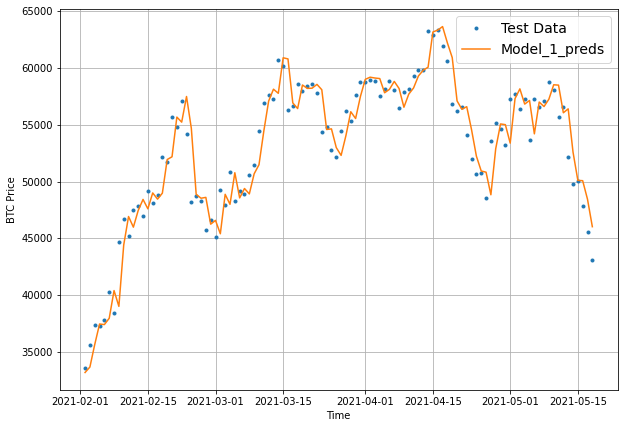

In [49]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
HORIZON = 1
WINDOW_SIZE = 30


In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [52]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [53]:
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2_history = model_2.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_2_dense")])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1423.9369 - mae: 1423.9369 - mse: 8234887.5000  

18/18 [==============================] - 1s 37ms/step - loss: 1423.9369 - mae: 1423.9369 - mse: 8234887.5000 - val_loss: 4811.8550 - val_mae: 4811.8550 - val_mse: 45592852.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 434.6313 - mae: 434.6313 - mse: 752194.2500 

18/18 [==============================] - 0s 29ms/step - loss: 432.5127 - mae: 432.5127 - mse: 745993.7500 - val_loss: 1902.0432 - val_mae: 1902.0432 - val_mse: 9690479.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 285.6210 - mae: 285.6210 - mse: 520290.8125

18/18 [==============================] - 1s 44ms/step - loss: 279.8045 - mae: 279.8045 - mse: 381636.1250 - val_loss: 1398.7346 - val_mae: 1398.7346 - val_mse: 6268300.5000
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 240.8707 - mae: 240.8707 - mse: 293086.5312

18/18 [==============================] - 1s 31ms/step - loss: 246.8233 - mae: 246.8233 - mse: 299450.6562 - val_loss: 1301.6986 - val_mae: 1301.6986 - val_mse: 5453792.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 199.7374 - mae: 199.7374 - mse: 158872.1562

18/18 [==============================] - 1s 53ms/step - loss: 233.2317 - mae: 233.2317 - mse: 263076.8750 - val_loss: 1286.2244 - val_mae: 1286.2244 - val_mse: 5036868.5000
Epoch 6/100
18/18 [==============================] - 0s 14ms/step - loss: 227.6144 - mae: 227.6144 - mse: 256606.9688 - val_loss: 1573.5192 - val_mae: 1573.5192 - val_mse: 6254513.5000
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 217.8940 - mae: 217.8940 - mse: 219684.0469

18/18 [==============================] - 1s 40ms/step - loss: 223.5335 - mae: 223.5335 - mse: 233017.3125 - val_loss: 1135.9257 - val_mae: 1135.9257 - val_mse: 4233834.5000
Epoch 8/100
12/18 [===================>..........] - ETA: 0s - loss: 224.8975 - mae: 224.8975 - mse: 253283.6406

18/18 [==============================] - 1s 73ms/step - loss: 221.2859 - mae: 221.2859 - mse: 236731.4688 - val_loss: 1109.8939 - val_mae: 1109.8939 - val_mse: 4127302.0000
Epoch 9/100
18/18 [==============================] - 0s 18ms/step - loss: 196.4735 - mae: 196.4735 - mse: 191254.4531 - val_loss: 1116.0309 - val_mae: 1116.0309 - val_mse: 3857756.7500
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 195.1325 - mae: 195.1325 - mse: 189940.8438

18/18 [==============================] - 1s 62ms/step - loss: 191.5951 - mae: 191.5951 - mse: 182068.5312 - val_loss: 1055.7825 - val_mae: 1055.7825 - val_mse: 3750670.5000
Epoch 11/100
18/18 [==============================] - 0s 13ms/step - loss: 183.5077 - mae: 183.5077 - mse: 171674.7969 - val_loss: 1071.1340 - val_mae: 1071.1340 - val_mse: 3478535.7500
Epoch 12/100
15/18 [========================>.....] - ETA: 0s - loss: 180.2912 - mae: 180.2912 - mse: 167058.7344

18/18 [==============================] - 2s 135ms/step - loss: 179.8392 - mae: 179.8392 - mse: 164801.0312 - val_loss: 992.6254 - val_mae: 992.6254 - val_mse: 3273810.0000
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 182.8612 - mae: 182.8612 - mse: 163390.9531 - val_loss: 1017.8839 - val_mae: 1017.8839 - val_mse: 3442882.7500
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 221.1257 - mae: 221.1257 - mse: 254481.7500

18/18 [==============================] - 0s 27ms/step - loss: 170.9381 - mae: 170.9381 - mse: 151755.4375 - val_loss: 943.7562 - val_mae: 943.7562 - val_mse: 2912077.2500
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 180.9776 - mae: 180.9776 - mse: 154485.2656 - val_loss: 1299.5682 - val_mae: 1299.5682 - val_mse: 5087478.5000
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 238.5362 - mae: 238.5362 - mse: 224119.6875

18/18 [==============================] - 0s 28ms/step - loss: 192.9956 - mae: 192.9956 - mse: 175559.5625 - val_loss: 941.8587 - val_mae: 941.8587 - val_mse: 2751034.5000
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 160.1376 - mae: 160.1376 - mse: 133276.1562 - val_loss: 1128.0648 - val_mae: 1128.0648 - val_mse: 3417135.7500
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 168.5518 - mae: 168.5518 - mse: 140475.4219 - val_loss: 1110.0328 - val_mae: 1110.0328 - val_mse: 3315109.7500
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 161.1118 - mae: 161.1118 - mse: 129207.1016 - val_loss: 1032.0806 - val_mae: 1032.0806 - val_mse: 3377003.2500
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 195.3514 - mae: 195.3514 - mse: 177421.3750

18/18 [==============================] - 0s 27ms/step - loss: 159.5945 - mae: 159.5945 - mse: 130426.5703 - val_loss: 854.8561 - val_mae: 854.8561 - val_mse: 2372589.7500
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 174.7325 - mae: 174.7325 - mse: 143950.3750 - val_loss: 887.3600 - val_mae: 887.3600 - val_mse: 2591618.7500
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 149.2507 - mae: 149.2507 - mse: 112782.3984 - val_loss: 894.5078 - val_mae: 894.5078 - val_mse: 2385599.0000
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 184.0700 - mae: 184.0700 - mse: 125034.2891

18/18 [==============================] - 0s 27ms/step - loss: 154.9610 - mae: 154.9610 - mse: 118272.7734 - val_loss: 847.6835 - val_mae: 847.6835 - val_mse: 2221608.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 174.5032 - mae: 174.5032 - mse: 122237.1562

18/18 [==============================] - 1s 30ms/step - loss: 145.3729 - mae: 145.3729 - mse: 110390.3359 - val_loss: 813.3804 - val_mae: 813.3804 - val_mse: 2187981.5000
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 154.8289 - mae: 154.8289 - mse: 118166.5391 - val_loss: 1017.8661 - val_mae: 1017.8661 - val_mse: 2801950.5000
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 154.2155 - mae: 154.2155 - mse: 117904.5859 - val_loss: 985.0917 - val_mae: 985.0917 - val_mse: 3018459.2500
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 174.3786 - mae: 174.3786 - mse: 139014.6250 - val_loss: 885.9189 - val_mae: 885.9189 - val_mse: 2532210.2500
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 161.9302 - mae: 161.9302 - mse: 124522.3594 - val_loss: 848.9034 - val_mae: 848.9034 - val_mse: 2345671.0000
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 144.2090 - mae: 144.2

18/18 [==============================] - 0s 28ms/step - loss: 147.3689 - mae: 147.3689 - mse: 104186.7656 - val_loss: 798.9645 - val_mae: 798.9645 - val_mse: 1941239.6250
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.3684 - mae: 142.3684 - mse: 77143.2656

18/18 [==============================] - 0s 28ms/step - loss: 138.1408 - mae: 138.1408 - mse: 98111.1719 - val_loss: 729.9893 - val_mae: 729.9893 - val_mse: 1758976.1250
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 132.7044 - mae: 132.7044 - mse: 94930.5469 - val_loss: 756.0147 - val_mae: 756.0147 - val_mse: 1785729.6250
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 135.1562 - mae: 135.1562 - mse: 96499.3438 - val_loss: 799.5488 - val_mae: 799.5488 - val_mse: 1919195.2500
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 150.7209 - mae: 150.7209 - mse: 108170.0000 - val_loss: 974.5299 - val_mae: 974.5299 - val_mse: 2531463.2500
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 212.9453 - mae: 212.9453 - mse: 178319.7500 - val_loss: 2022.4769 - val_mae: 2022.4769 - val_mse: 9100833.0000
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 195.2749 - mae: 195.2749

18/18 [==============================] - 1s 43ms/step - loss: 132.8997 - mae: 132.8997 - mse: 92254.7812 - val_loss: 690.1313 - val_mae: 690.1313 - val_mse: 1586019.6250
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 128.2288 - mae: 128.2288 - mse: 82171.4219

18/18 [==============================] - 0s 29ms/step - loss: 128.1820 - mae: 128.1820 - mse: 87527.7422 - val_loss: 686.7181 - val_mae: 686.7181 - val_mse: 1564640.5000
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 106.4164 - mae: 106.4164 - mse: 66073.5234

18/18 [==============================] - 0s 29ms/step - loss: 135.6674 - mae: 135.6674 - mse: 89403.8438 - val_loss: 680.0854 - val_mae: 680.0854 - val_mse: 1527630.2500
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 144.0407 - mae: 144.0407 - mse: 107484.3750 - val_loss: 760.3464 - val_mae: 760.3464 - val_mse: 1753221.0000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 142.6828 - mae: 142.6828 - mse: 96585.6406 - val_loss: 792.7310 - val_mae: 792.7310 - val_mse: 1856780.3750
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 129.9967 - mae: 129.9967 - mse: 88849.6875 - val_loss: 973.1512 - val_mae: 973.1512 - val_mse: 2467852.7500
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 156.4066 - mae: 156.4066 - mse: 111542.0078 - val_loss: 1200.4486 - val_mae: 1200.4486 - val_mse: 3776194.0000
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 142.6149 - mae: 142.6149

18/18 [==============================] - 1s 29ms/step - loss: 153.7966 - mae: 153.7966 - mse: 111195.1484 - val_loss: 654.2715 - val_mae: 654.2715 - val_mse: 1421505.6250
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 149.6747 - mae: 149.6747 - mse: 103363.8359 - val_loss: 687.2487 - val_mae: 687.2487 - val_mse: 1538470.0000
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 141.0399 - mae: 141.0399 - mse: 93338.2109 - val_loss: 753.5208 - val_mae: 753.5208 - val_mse: 1776015.5000
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 162.8874 - mae: 162.8874 - mse: 115857.1406 - val_loss: 692.7845 - val_mae: 692.7845 - val_mse: 1519927.8750
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 142.2396 - mae: 142.2396 - mse: 94253.1641 - val_loss: 790.5832 - val_mae: 790.5832 - val_mse: 1816504.2500
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 128.0528 - mae: 128.0528 - ms

18/18 [==============================] - 1s 30ms/step - loss: 126.5788 - mae: 126.5788 - mse: 84568.2812 - val_loss: 644.4559 - val_mae: 644.4559 - val_mse: 1395489.0000
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.9568 - mae: 121.9568 - mse: 81746.0469 - val_loss: 847.9078 - val_mae: 847.9078 - val_mse: 2143907.7500
Epoch 63/100
11/18 [=================>............] - ETA: 0s - loss: 132.7043 - mae: 132.7043 - mse: 86507.0703 

18/18 [==============================] - 1s 74ms/step - loss: 133.0297 - mae: 133.0297 - mse: 90492.5781 - val_loss: 644.0168 - val_mae: 644.0168 - val_mse: 1379262.2500
Epoch 64/100
18/18 [==============================] - 0s 16ms/step - loss: 132.1211 - mae: 132.1211 - mse: 88953.0000 - val_loss: 654.7057 - val_mae: 654.7057 - val_mse: 1426013.8750
Epoch 65/100
18/18 [==============================] - 0s 15ms/step - loss: 144.7831 - mae: 144.7831 - mse: 97440.9375 - val_loss: 896.3775 - val_mae: 896.3774 - val_mse: 2323107.7500
Epoch 66/100
18/18 [==============================] - 0s 16ms/step - loss: 124.3790 - mae: 124.3790 - mse: 82972.4531 - val_loss: 654.8689 - val_mae: 654.8689 - val_mse: 1416951.8750
Epoch 67/100
18/18 [==============================] - 0s 14ms/step - loss: 119.5769 - mae: 119.5769 - mse: 79838.5469 - val_loss: 654.8334 - val_mae: 654.8334 - val_mse: 1394439.0000
Epoch 68/100
18/18 [==============================] - 0s 13ms/step - loss: 120.8876 - mae: 120.887

18/18 [==============================] - 1s 49ms/step - loss: 121.2443 - mae: 121.2443 - mse: 80481.5859 - val_loss: 625.1249 - val_mae: 625.1249 - val_mse: 1323776.2500
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 115.9945 - mae: 115.9945 - mse: 77058.8672 - val_loss: 697.0118 - val_mae: 697.0118 - val_mse: 1557653.3750
Epoch 73/100
15/18 [========================>.....] - ETA: 0s - loss: 139.1689 - mae: 139.1689 - mse: 97058.9609 

18/18 [==============================] - 1s 30ms/step - loss: 137.5648 - mae: 137.5648 - mse: 93005.0000 - val_loss: 622.4139 - val_mae: 622.4139 - val_mse: 1311550.2500
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 123.8153 - mae: 123.8153 - mse: 82861.7812 - val_loss: 627.9509 - val_mae: 627.9509 - val_mse: 1323221.3750
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 118.4581 - mae: 118.4581 - mse: 78208.6250 - val_loss: 696.9827 - val_mae: 696.9827 - val_mse: 1507926.3750
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 122.2844 - mae: 122.2844 - mse: 80516.9062 - val_loss: 716.7662 - val_mae: 716.7662 - val_mse: 1562099.8750
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 119.8859 - mae: 119.8859 - mse: 77788.3438 - val_loss: 690.7415 - val_mae: 690.7415 - val_mse: 1485008.8750
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 121.8183 - mae: 121.8183 - mse: 

18/18 [==============================] - 1s 29ms/step - loss: 119.7543 - mae: 119.7543 - mse: 78891.8125 - val_loss: 616.5490 - val_mae: 616.5490 - val_mse: 1291381.6250
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 125.0209 - mae: 125.0209 - mse: 82573.4297 - val_loss: 671.0804 - val_mae: 671.0804 - val_mse: 1430283.1250
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 120.9935 - mae: 120.9935 - mse: 80087.2109 - val_loss: 709.3252 - val_mae: 709.3252 - val_mse: 1537474.7500
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 125.8356 - mae: 125.8356 - mse: 80143.0156 - val_loss: 743.4037 - val_mae: 743.4037 - val_mse: 1640574.8750
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 125.3469 - mae: 125.3469 - mse: 80049.7422 - val_loss: 665.9240 - val_mae: 665.9240 - val_mse: 1415730.8750
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 124.0770 - mae: 124.0770 - m

18/18 [==============================] - 1s 50ms/step - loss: 141.0114 - mae: 141.0114 - mse: 91460.6875 - val_loss: 612.6856 - val_mae: 612.6856 - val_mse: 1278644.6250
Epoch 85/100
11/18 [=================>............] - ETA: 0s - loss: 127.8592 - mae: 127.8592 - mse: 76034.2031

18/18 [==============================] - 1s 34ms/step - loss: 142.6072 - mae: 142.6072 - mse: 99576.1172 - val_loss: 608.7708 - val_mae: 608.7708 - val_mse: 1268336.7500
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 116.4635 - mae: 116.4635 - mse: 75735.8906 - val_loss: 626.8029 - val_mae: 626.8029 - val_mse: 1304289.2500
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 132.6135 - mae: 132.6135 - mse: 87986.1875 - val_loss: 931.2136 - val_mae: 931.2136 - val_mse: 2399794.5000
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 150.6984 - mae: 150.6984 - mse: 100095.1094 - val_loss: 638.1904 - val_mae: 638.1904 - val_mse: 1359327.2500
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6291 - mae: 115.6291 - mse: 76069.8516 - val_loss: 1165.2830 - val_mae: 1165.2830 - val_mse: 3169479.5000
Epoch 90/100
 1/18 [>.............................] - ETA: 0s - loss: 188.5858 - mae: 188.5858 - ms

18/18 [==============================] - 1s 36ms/step - loss: 130.1917 - mae: 130.1917 - mse: 88806.2422 - val_loss: 607.2518 - val_mae: 607.2518 - val_mse: 1254143.0000
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 114.4669 - mae: 114.4669 - mse: 73898.5469 - val_loss: 611.8282 - val_mae: 611.8282 - val_mse: 1270328.1250
Epoch 92/100
18/18 [==============================] - 0s 10ms/step - loss: 113.0718 - mae: 113.0718 - mse: 74893.7188 - val_loss: 725.2574 - val_mae: 725.2574 - val_mse: 1575905.6250
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 147.5808 - mae: 147.5808 - mse: 101080.0391 - val_loss: 864.8488 - val_mae: 864.8488 - val_mse: 2015303.8750
Epoch 94/100
17/18 [===========================>..] - ETA: 0s - loss: 153.2574 - mae: 153.2574 - mse: 100879.2734

18/18 [==============================] - 1s 31ms/step - loss: 153.6805 - mae: 153.6805 - mse: 103522.7500 - val_loss: 603.9781 - val_mae: 603.9781 - val_mse: 1251337.7500
Epoch 95/100
18/18 [==============================] - 0s 9ms/step - loss: 126.5529 - mae: 126.5529 - mse: 82697.1094 - val_loss: 719.7612 - val_mae: 719.7612 - val_mse: 1594217.0000
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 136.1355 - mae: 136.1355 - mse: 92464.4219 - val_loss: 681.1370 - val_mae: 681.1370 - val_mse: 1473264.8750
Epoch 97/100
18/18 [==============================] - 0s 8ms/step - loss: 129.7863 - mae: 129.7863 - mse: 84852.6484 - val_loss: 793.3242 - val_mae: 793.3242 - val_mse: 1856843.8750
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 145.3431 - mae: 145.3431 - mse: 99314.8359 - val_loss: 669.1981 - val_mae: 669.1981 - val_mse: 1426273.2500
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 136.1109 - mae: 136.1109 - 

In [54]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 627.8910 - mae: 627.8910 - mse: 1298184.6250


[627.8909912109375, 627.8909912109375, 1298184.625]

In [55]:
# Load in the best performing model and evaluate 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.9783 - mae: 603.9783 - mse: 1251337.7500


[603.978271484375, 603.978271484375, 1251337.75]

In [56]:
# get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 5ms/step


In [57]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 603.9783,
 'mse': 1251337.9,
 'rmse': 1118.6321,
 'mape': 2.6817548,
 'mase': 1.0557599}

In [58]:
model_1_results

{'mae': 568.7688,
 'mse': 1160735.1,
 'rmse': 1077.3741,
 'mape': 2.5498853,
 'mase': 0.99916923}

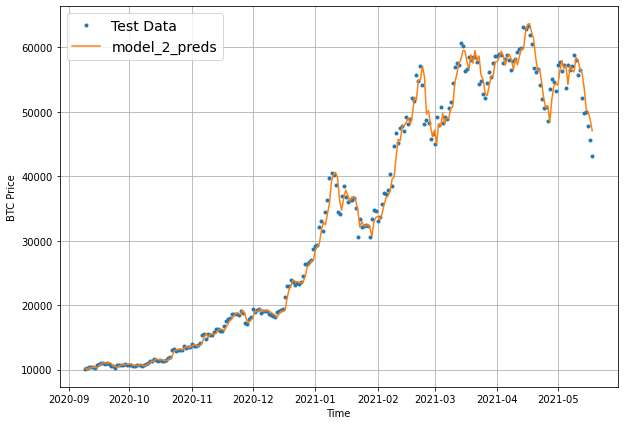

In [59]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)


In [60]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_labels,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

In [62]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_3_history = model_3.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_3_dense")])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 2517.3286 - mae: 2517.3286 - mse: 18709540.0000 

18/18 [==============================] - 2s 57ms/step - loss: 2260.1023 - mae: 2260.1023 - mse: 16045194.0000 - val_loss: 7949.2324 - val_mae: 7949.2324 - val_mse: 179961536.0000
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 806.8443 - mae: 806.8443 - mse: 3180578.0000  

18/18 [==============================] - 1s 41ms/step - loss: 743.1441 - mae: 743.1441 - mse: 2759915.5000 - val_loss: 1779.6617 - val_mae: 1779.6617 - val_mse: 10688257.0000
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 211.3409 - mae: 211.3409 - mse: 204184.7656

18/18 [==============================] - 1s 37ms/step - loss: 206.0927 - mae: 206.0927 - mse: 198680.2500 - val_loss: 850.1873 - val_mae: 850.1873 - val_mse: 2531113.5000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 142.7634 - mae: 142.7634 - mse: 104745.5781

18/18 [==============================] - 0s 29ms/step - loss: 142.5288 - mae: 142.5288 - mse: 104191.3750 - val_loss: 683.3096 - val_mae: 683.3096 - val_mse: 1639428.7500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 163.9017 - mae: 163.9017 - mse: 150065.7969

18/18 [==============================] - 0s 29ms/step - loss: 127.5427 - mae: 127.5427 - mse: 92957.3906 - val_loss: 681.7020 - val_mae: 681.7020 - val_mse: 1599889.6250
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 123.3702 - mae: 123.3702 - mse: 87025.8047

18/18 [==============================] - 0s 29ms/step - loss: 121.9103 - mae: 121.9103 - mse: 85112.0000 - val_loss: 659.4156 - val_mae: 659.4156 - val_mse: 1501564.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 118.6554 - mae: 118.6554 - mse: 90900.2031

18/18 [==============================] - 1s 37ms/step - loss: 118.6130 - mae: 118.6130 - mse: 80817.7031 - val_loss: 632.0942 - val_mae: 632.0942 - val_mse: 1393215.2500
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 116.2240 - mae: 116.2240 - mse: 76946.1484 - val_loss: 646.6307 - val_mae: 646.6307 - val_mse: 1398754.8750
Epoch 9/100
13/18 [====================>.........] - ETA: 0s - loss: 118.8506 - mae: 118.8506 - mse: 74853.9219

18/18 [==============================] - 1s 49ms/step - loss: 116.5810 - mae: 116.5810 - mse: 75768.4609 - val_loss: 617.9484 - val_mae: 617.9484 - val_mse: 1299598.2500
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 109.4405 - mae: 109.4405 - mse: 64656.2578

18/18 [==============================] - 1s 40ms/step - loss: 110.3704 - mae: 110.3704 - mse: 69018.0469 - val_loss: 586.2383 - val_mae: 586.2383 - val_mse: 1199577.5000
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 108.7628 - mae: 108.7628 - mse: 67930.3984

18/18 [==============================] - 1s 34ms/step - loss: 107.9643 - mae: 107.9643 - mse: 66191.1641 - val_loss: 564.4438 - val_mae: 564.4438 - val_mse: 1106268.8750
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 103.5047 - mae: 103.5047 - mse: 61453.1211

18/18 [==============================] - 1s 29ms/step - loss: 103.5047 - mae: 103.5047 - mse: 61453.1211 - val_loss: 563.8218 - val_mae: 563.8218 - val_mse: 1077672.0000
Epoch 13/100
17/18 [===========================>..] - ETA: 0s - loss: 101.1097 - mae: 101.1097 - mse: 58580.6641

18/18 [==============================] - 1s 32ms/step - loss: 101.0072 - mae: 101.0072 - mse: 58312.4375 - val_loss: 526.3788 - val_mae: 526.3788 - val_mse: 975242.5625
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 95.5034 - mae: 95.5034 - mse: 51795.6641

18/18 [==============================] - 1s 36ms/step - loss: 97.8968 - mae: 97.8968 - mse: 54604.5078 - val_loss: 526.3339 - val_mae: 526.3339 - val_mse: 942540.1875
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 93.9716 - mae: 93.9716 - mse: 46915.8203

18/18 [==============================] - 1s 48ms/step - loss: 94.8267 - mae: 94.8267 - mse: 51581.0781 - val_loss: 501.3782 - val_mae: 501.3782 - val_mse: 856537.6875
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 94.8006 - mae: 94.8006 - mse: 51166.3203

18/18 [==============================] - 1s 31ms/step - loss: 93.0208 - mae: 93.0208 - mse: 49200.5078 - val_loss: 480.0225 - val_mae: 480.0225 - val_mse: 794191.0625
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 88.5804 - mae: 88.5804 - mse: 44370.9727 - val_loss: 491.8712 - val_mae: 491.8712 - val_mse: 779612.4375
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 85.6642 - mae: 85.6642 - mse: 41515.4219

18/18 [==============================] - 1s 36ms/step - loss: 85.0480 - mae: 85.0480 - mse: 40831.9727 - val_loss: 435.4296 - val_mae: 435.4296 - val_mse: 656705.2500
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 80.9500 - mae: 80.9500 - mse: 37962.4414

18/18 [==============================] - 1s 31ms/step - loss: 81.0320 - mae: 81.0320 - mse: 37717.9219 - val_loss: 433.8733 - val_mae: 433.8733 - val_mse: 633789.5625
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 87.2702 - mae: 87.2702 - mse: 43148.1289

18/18 [==============================] - 1s 29ms/step - loss: 79.9908 - mae: 79.9908 - mse: 36353.1602 - val_loss: 415.5498 - val_mae: 415.5498 - val_mse: 583375.6250
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 77.8629 - mae: 77.8629 - mse: 33834.0859

18/18 [==============================] - 1s 33ms/step - loss: 77.7655 - mae: 77.7655 - mse: 33753.6094 - val_loss: 405.6492 - val_mae: 405.6492 - val_mse: 551952.2500
Epoch 22/100
12/18 [===================>..........] - ETA: 0s - loss: 74.0427 - mae: 74.0427 - mse: 32508.9609

18/18 [==============================] - 1s 57ms/step - loss: 74.2213 - mae: 74.2213 - mse: 31663.0918 - val_loss: 399.5597 - val_mae: 399.5597 - val_mse: 521073.9375
Epoch 23/100
 7/18 [==========>...................] - ETA: 0s - loss: 70.0356 - mae: 70.0356 - mse: 28752.4805

18/18 [==============================] - 1s 71ms/step - loss: 73.1517 - mae: 73.1517 - mse: 30481.3945 - val_loss: 379.7112 - val_mae: 379.7112 - val_mse: 477834.0625
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 71.9734 - mae: 71.9734 - mse: 28191.0098

18/18 [==============================] - 1s 36ms/step - loss: 71.1980 - mae: 71.1980 - mse: 28230.7812 - val_loss: 364.7260 - val_mae: 364.7260 - val_mse: 447204.2812
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 69.0620 - mae: 69.0620 - mse: 28245.8066

18/18 [==============================] - 1s 37ms/step - loss: 67.9463 - mae: 67.9463 - mse: 26533.0254 - val_loss: 363.1476 - val_mae: 363.1476 - val_mse: 434868.4375
Epoch 26/100
10/18 [===============>..............] - ETA: 0s - loss: 66.5663 - mae: 66.5663 - mse: 22377.7812

18/18 [==============================] - 1s 31ms/step - loss: 66.9614 - mae: 66.9614 - mse: 25030.0527 - val_loss: 354.9222 - val_mae: 354.9222 - val_mse: 404703.0312
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 67.4629 - mae: 67.4629 - mse: 25154.7891

18/18 [==============================] - 1s 31ms/step - loss: 66.7822 - mae: 66.7822 - mse: 24843.8926 - val_loss: 346.6172 - val_mae: 346.6172 - val_mse: 390676.4375
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 64.9638 - mae: 64.9638 - mse: 23519.0938 - val_loss: 348.9784 - val_mae: 348.9784 - val_mse: 396492.3125
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 67.1587 - mae: 67.1587 - mse: 23927.6680

18/18 [==============================] - 1s 30ms/step - loss: 62.3337 - mae: 62.3337 - mse: 21974.9082 - val_loss: 318.9150 - val_mae: 318.9150 - val_mse: 336274.8438
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 60.6713 - mae: 60.6713 - mse: 21053.2754 - val_loss: 324.6486 - val_mae: 324.6486 - val_mse: 345741.2812
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 61.9938 - mae: 61.9938 - mse: 20924.4707 - val_loss: 327.3347 - val_mae: 327.3347 - val_mse: 342867.2812
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 59.5380 - mae: 59.5380 - mse: 19911.3125 - val_loss: 328.1212 - val_mae: 328.1212 - val_mse: 347618.7188
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 59.1891 - mae: 59.1891 - mse: 19614.9805 - val_loss: 325.2013 - val_mae: 325.2013 - val_mse: 327652.0000
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 57.4923 - mae: 57.4923 - mse: 18534.8848 - 

18/18 [==============================] - 1s 29ms/step - loss: 57.9818 - mae: 57.9818 - mse: 18282.1230 - val_loss: 295.6275 - val_mae: 295.6275 - val_mse: 287647.0625
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 55.3755 - mae: 55.3755 - mse: 17350.9746 - val_loss: 299.5155 - val_mae: 299.5155 - val_mse: 281507.7188
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 54.5266 - mae: 54.5266 - mse: 16829.9668 - val_loss: 296.9922 - val_mae: 296.9922 - val_mse: 285343.5938
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 55.6785 - mae: 55.6785 - mse: 16602.3516

18/18 [==============================] - 1s 30ms/step - loss: 54.4509 - mae: 54.4509 - mse: 16537.2207 - val_loss: 271.4677 - val_mae: 271.4677 - val_mse: 246503.2344
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 33.9902 - mae: 33.9902 - mse: 6169.4307

18/18 [==============================] - 1s 45ms/step - loss: 51.2333 - mae: 51.2333 - mse: 15154.8096 - val_loss: 269.3594 - val_mae: 269.3594 - val_mse: 239587.7656
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 50.2227 - mae: 50.2227 - mse: 14475.9004 - val_loss: 270.6621 - val_mae: 270.6621 - val_mse: 238281.8125
Epoch 41/100
18/18 [==============================] - 0s 10ms/step - loss: 49.2987 - mae: 49.2987 - mse: 14051.1885 - val_loss: 269.3807 - val_mae: 269.3807 - val_mse: 234724.0312
Epoch 42/100
17/18 [===========================>..] - ETA: 0s - loss: 49.2219 - mae: 49.2219 - mse: 13676.1436

18/18 [==============================] - 1s 39ms/step - loss: 49.0708 - mae: 49.0708 - mse: 13589.4014 - val_loss: 265.6075 - val_mae: 265.6075 - val_mse: 222615.0000
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 49.0900 - mae: 49.0900 - mse: 13476.4531 - val_loss: 268.1146 - val_mae: 268.1146 - val_mse: 230839.2344
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 50.5434 - mae: 50.5434 - mse: 13947.2822

18/18 [==============================] - 1s 44ms/step - loss: 48.2717 - mae: 48.2717 - mse: 13099.2393 - val_loss: 242.9592 - val_mae: 242.9592 - val_mse: 194322.1562
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 46.5011 - mae: 46.5011 - mse: 12382.2705 - val_loss: 263.8344 - val_mae: 263.8344 - val_mse: 221155.2656
Epoch 46/100
18/18 [==============================] - 0s 11ms/step - loss: 45.4047 - mae: 45.4047 - mse: 11918.2939 - val_loss: 252.5126 - val_mae: 252.5126 - val_mse: 205587.3750
Epoch 47/100
17/18 [===========================>..] - ETA: 0s - loss: 44.7388 - mae: 44.7388 - mse: 11536.7646

18/18 [==============================] - 1s 35ms/step - loss: 44.8093 - mae: 44.8093 - mse: 11579.2510 - val_loss: 236.4667 - val_mae: 236.4667 - val_mse: 184493.3125
Epoch 48/100
18/18 [==============================] - ETA: 0s - loss: 43.9393 - mae: 43.9393 - mse: 11007.9014

18/18 [==============================] - 1s 32ms/step - loss: 43.9393 - mae: 43.9393 - mse: 11007.9014 - val_loss: 231.2564 - val_mae: 231.2564 - val_mse: 175048.5469
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 44.3281 - mae: 44.3281 - mse: 11030.1553 - val_loss: 244.9373 - val_mae: 244.9373 - val_mse: 188374.0312
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 48.7286 - mae: 48.7286 - mse: 10956.7656

18/18 [==============================] - 1s 35ms/step - loss: 43.4277 - mae: 43.4277 - mse: 10477.6064 - val_loss: 216.7421 - val_mae: 216.7421 - val_mse: 155336.3750
Epoch 51/100
13/18 [====================>.........] - ETA: 0s - loss: 40.1305 - mae: 40.1305 - mse: 9366.5850

18/18 [==============================] - 1s 46ms/step - loss: 40.9781 - mae: 40.9781 - mse: 9821.8662 - val_loss: 212.6732 - val_mae: 212.6732 - val_mse: 149514.3438
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 39.9216 - mae: 39.9216 - mse: 9479.1084 - val_loss: 214.8821 - val_mae: 214.8821 - val_mse: 147369.9844
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 40.2311 - mae: 40.2311 - mse: 9256.7500 - val_loss: 212.7408 - val_mae: 212.7408 - val_mse: 150182.8906
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 38.7119 - mae: 38.7119 - mse: 8692.1875 - val_loss: 235.6293 - val_mae: 235.6293 - val_mse: 165824.0625
Epoch 55/100
18/18 [==============================] - 0s 8ms/step - loss: 38.9492 - mae: 38.9492 - mse: 8622.9570 - val_loss: 220.3412 - val_mae: 220.3412 - val_mse: 154849.3125
Epoch 56/100
15/18 [========================>.....] - ETA: 0s - loss: 37.9831 - mae: 37.9831 - mse: 8417.8877

18/18 [==============================] - 1s 65ms/step - loss: 38.1477 - mae: 38.1477 - mse: 8413.4902 - val_loss: 204.0436 - val_mae: 204.0436 - val_mse: 136495.6094
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 38.2651 - mae: 38.2651 - mse: 8128.3193

18/18 [==============================] - 1s 43ms/step - loss: 37.0284 - mae: 37.0284 - mse: 8009.8999 - val_loss: 196.3584 - val_mae: 196.3584 - val_mse: 129477.4141
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 35.0763 - mae: 35.0763 - mse: 7307.7085

18/18 [==============================] - 1s 47ms/step - loss: 35.4638 - mae: 35.4638 - mse: 7425.4941 - val_loss: 188.8369 - val_mae: 188.8369 - val_mse: 117294.8516
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 35.6678 - mae: 35.6678 - mse: 7361.7090 - val_loss: 202.0890 - val_mae: 202.0890 - val_mse: 127621.5469
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 36.1193 - mae: 36.1193 - mse: 7389.7773 - val_loss: 221.8275 - val_mae: 221.8275 - val_mse: 148939.4688
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 36.1001 - mae: 36.1001 - mse: 7206.0894 - val_loss: 209.4833 - val_mae: 209.4833 - val_mse: 132790.7344
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 36.8853 - mae: 36.8853 - mse: 7202.0796 - val_loss: 189.0436 - val_mae: 189.0436 - val_mse: 110768.8359
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 33.8436 - mae: 33.8436 - mse: 6495.9043 - val_lo

18/18 [==============================] - 1s 30ms/step - loss: 33.4414 - mae: 33.4414 - mse: 6389.1963 - val_loss: 167.5991 - val_mae: 167.5991 - val_mse: 95146.5234
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 31.6023 - mae: 31.6023 - mse: 5970.1655 - val_loss: 181.0720 - val_mae: 181.0720 - val_mse: 103940.7109
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 23.8379 - mae: 23.8379 - mse: 3130.9817

18/18 [==============================] - 1s 33ms/step - loss: 31.0897 - mae: 31.0897 - mse: 5755.1450 - val_loss: 157.9622 - val_mae: 157.9622 - val_mse: 85297.1562
Epoch 67/100
18/18 [==============================] - 0s 8ms/step - loss: 29.8913 - mae: 29.8913 - mse: 5444.9395 - val_loss: 170.6099 - val_mae: 170.6099 - val_mse: 94992.6953
Epoch 68/100
18/18 [==============================] - 0s 11ms/step - loss: 30.1499 - mae: 30.1499 - mse: 5347.5850 - val_loss: 183.8903 - val_mae: 183.8903 - val_mse: 109765.1797
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 31.2955 - mae: 31.2955 - mse: 5613.8750 - val_loss: 200.9961 - val_mae: 200.9961 - val_mse: 119454.4062
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 31.6032 - mae: 31.6032 - mse: 5372.6597 - val_loss: 170.0128 - val_mae: 170.0128 - val_mse: 86903.1016
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 28.8961 - mae: 28.8961 - mse: 4762.1299 - val_loss

18/18 [==============================] - 1s 37ms/step - loss: 26.2590 - mae: 26.2590 - mse: 3920.8813 - val_loss: 150.3446 - val_mae: 150.3446 - val_mse: 68097.7500
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 25.4280 - mae: 25.4280 - mse: 3648.9814 - val_loss: 179.5071 - val_mae: 179.5071 - val_mse: 91834.8281
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 31.8663 - mae: 31.8663 - mse: 4848.0596

18/18 [==============================] - 1s 35ms/step - loss: 26.4824 - mae: 26.4824 - mse: 3903.2874 - val_loss: 150.0683 - val_mae: 150.0683 - val_mse: 68890.3047
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 25.2133 - mae: 25.2133 - mse: 3449.1609 - val_loss: 157.8142 - val_mae: 157.8142 - val_mse: 74021.2734
Epoch 82/100
15/18 [========================>.....] - ETA: 0s - loss: 24.8415 - mae: 24.8415 - mse: 3203.9062

18/18 [==============================] - 1s 45ms/step - loss: 24.8722 - mae: 24.8722 - mse: 3329.6860 - val_loss: 146.1702 - val_mae: 146.1702 - val_mse: 67993.3984
Epoch 83/100
17/18 [===========================>..] - ETA: 0s - loss: 23.6473 - mae: 23.6473 - mse: 3156.5149

18/18 [==============================] - 1s 30ms/step - loss: 23.5556 - mae: 23.5556 - mse: 3137.7507 - val_loss: 130.7025 - val_mae: 130.7025 - val_mse: 53182.7578
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 22.7403 - mae: 22.7403 - mse: 2983.1643 - val_loss: 139.7543 - val_mae: 139.7543 - val_mse: 61072.1445
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 24.9550 - mae: 24.9550 - mse: 3409.6941 - val_loss: 145.3020 - val_mae: 145.3020 - val_mse: 67811.4688
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 24.1867 - mae: 24.1867 - mse: 3222.0554 - val_loss: 133.3706 - val_mae: 133.3706 - val_mse: 58039.6094
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 26.5382 - mae: 26.5382 - mse: 3400.0952 - val_loss: 139.7497 - val_mae: 139.7497 - val_mse: 55162.7148
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 24.4777 - mae: 24.4777 - mse: 3057.1821 - val_loss: 1

18/18 [==============================] - 1s 66ms/step - loss: 20.8848 - mae: 20.8848 - mse: 2459.3091 - val_loss: 109.9478 - val_mae: 109.9478 - val_mse: 41754.0508
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 19.1382 - mae: 19.1382 - mse: 2177.5786 - val_loss: 116.5275 - val_mae: 116.5275 - val_mse: 42186.7422
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 19.3568 - mae: 19.3568 - mse: 2181.4885 - val_loss: 110.0143 - val_mae: 110.0143 - val_mse: 37323.6914
Epoch 93/100
18/18 [==============================] - 0s 15ms/step - loss: 22.5953 - mae: 22.5953 - mse: 2466.6865 - val_loss: 151.3702 - val_mae: 151.3702 - val_mse: 64493.8711
Epoch 94/100
17/18 [===========================>..] - ETA: 0s - loss: 21.2968 - mae: 21.2968 - mse: 2363.8628

18/18 [==============================] - 2s 94ms/step - loss: 21.1437 - mae: 21.1437 - mse: 2340.7715 - val_loss: 101.9475 - val_mae: 101.9475 - val_mse: 32037.3691
Epoch 95/100
18/18 [==============================] - 0s 7ms/step - loss: 20.4111 - mae: 20.4111 - mse: 2114.0964 - val_loss: 158.2258 - val_mae: 158.2258 - val_mse: 67339.9922
Epoch 96/100
18/18 [==============================] - 0s 12ms/step - loss: 22.7325 - mae: 22.7325 - mse: 2469.2539 - val_loss: 116.0575 - val_mae: 116.0575 - val_mse: 41887.3828
Epoch 97/100
16/18 [=========================>....] - ETA: 0s - loss: 19.5898 - mae: 19.5898 - mse: 2029.3608

18/18 [==============================] - 1s 49ms/step - loss: 19.2315 - mae: 19.2315 - mse: 1989.8307 - val_loss: 98.2353 - val_mae: 98.2353 - val_mse: 29430.7559
Epoch 98/100
18/18 [==============================] - 0s 9ms/step - loss: 17.9794 - mae: 17.9794 - mse: 1724.4066 - val_loss: 107.0502 - val_mae: 107.0502 - val_mse: 33487.8203
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 17.2381 - mae: 17.2381 - mse: 1597.5382

18/18 [==============================] - 1s 30ms/step - loss: 17.3200 - mae: 17.3200 - mse: 1610.6339 - val_loss: 91.6987 - val_mae: 91.6987 - val_mse: 27817.3691
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 16.6523 - mae: 16.6523 - mse: 1574.8939 - val_loss: 100.1520 - val_mae: 100.1520 - val_mse: 29039.5215


In [63]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 100.1520 - mae: 100.1520 - mse: 29039.5195


[100.15203094482422, 100.15203094482422, 29039.51953125]

In [64]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 91.6986 - mae: 91.6986 - mse: 27817.3711


[91.69864654541016, 91.69864654541016, 27817.37109375]

In [65]:
# Make predictions 
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:3]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[8812.635 , 8839.984 , 9066.737 , 8731.8955, 8809.215 , 8715.988 ,
        8689.652 ],
       [8831.237 , 9057.629 , 8766.112 , 8749.183 , 8792.369 , 8626.687 ,
        8475.245 ],
       [9086.578 , 8783.6   , 8773.634 , 8708.122 , 8692.903 , 8486.376 ,
        8465.339 ]], dtype=float32)>

In [66]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': array([ 29.937918,  31.653181,  26.53125 ,  29.769114,  30.583706,
         16.334751,  39.680523,  38.12765 ,  14.804548,  37.983257,
         34.689106,  19.804478,  39.442314,  18.468401,  38.281807,
         23.192244,  43.072823,  28.763882,  39.54534 ,  29.177036,
         26.489048,  22.371023,  30.750837,  15.947963,  22.378279,
         28.24414 ,  15.237654,  29.35826 ,  18.757883,  21.97433 ,
         24.44636 ,  16.33768 ,  30.093401,  21.14174 ,  51.57017 ,
         58.96519 ,  46.482353,  59.603725,  48.183315,  43.09675 ,
         27.291853,  23.123953,  15.446498,  24.233957,  23.196218,
         20.512417,  21.306223,  16.535715,  27.29011 ,  23.687012,
         23.78425 ,  38.08252 ,  18.910715,  36.271065,  32.884068,
         25.99414 ,  20.871653,  31.54562 ,  38.103935,  18.514648,
         33.334404,  33.339775,  45.460518,  31.683035,  38.58315 ,
         43.032505,  38.09082 ,  25.597656,  39.800503,  22.645926,
         21.725027,  26.652761,  34.04729

## Make our evaluation function work for larger horizons


In [67]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [68]:
# Get model_3 results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 91.69865,
 'mse': 27817.371,
 'rmse': 113.171295,
 'mape': 0.4424562,
 'mase': 0.1631726}

In [69]:
model_2_results

{'mae': 603.9783,
 'mse': 1251337.9,
 'rmse': 1118.6321,
 'mape': 2.6817548,
 'mase': 1.0557599}

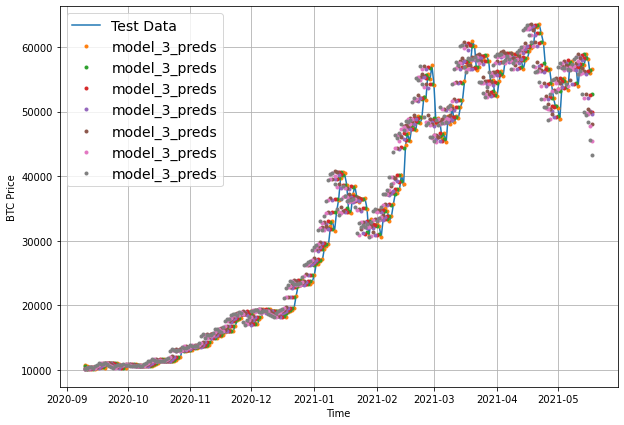

In [70]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

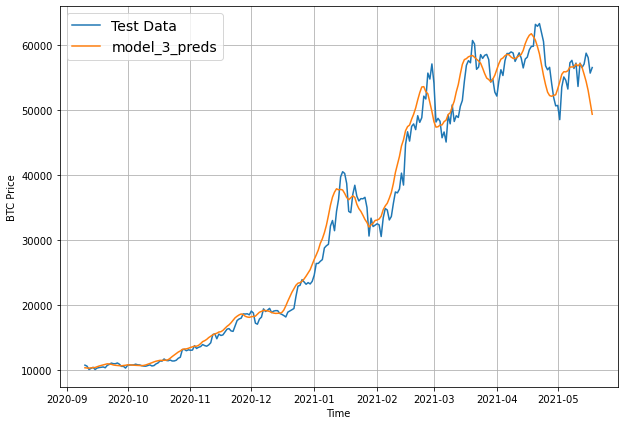

In [71]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

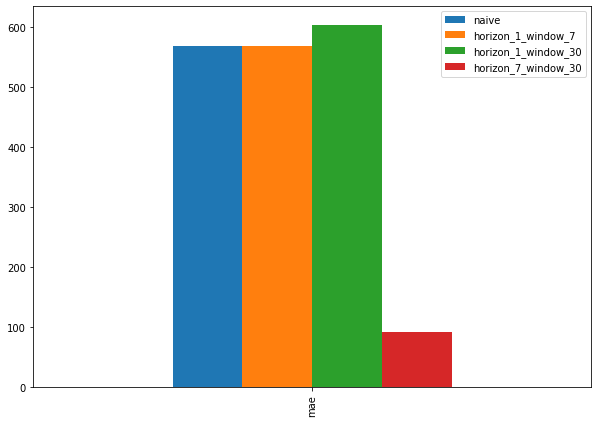

In [72]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


> 🔑 **Note:** You might be wondering, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation i means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

> 📖 **Resources:** For more on how autocorrelation influences a model's predictions, see the arcticle [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik.](https://www.kdnuggets.com/2020/03/machine-learning-time-series-forecasting-sequel.html)

## Model 4: Conv1D



In [73]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [74]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


(2780, 2780)

In [75]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However, our data isn't in that shape yet...


In [76]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [77]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [78]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) #  add an extra dimension for `input_dim`


In [79]:
# Test out our lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [80]:
# Create Conv1D
# Set random seed
tf.random.set_seed(42)

# Create model_4
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile model
model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])


In [81]:
model_4.fit(train_windows, train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1987.5090 - mae: 1987.5090  

18/18 [==============================] - 8s 53ms/step - loss: 1787.5032 - mae: 1787.5032 - val_loss: 1235.3312 - val_mae: 1235.3312
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 337.9433 - mae: 337.9433 - val_loss: 1673.0065 - val_mae: 1673.0065
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 235.6008 - mae: 235.6008

18/18 [==============================] - 1s 39ms/step - loss: 233.5363 - mae: 233.5363 - val_loss: 1129.4529 - val_mae: 1129.4529
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 202.0518 - mae: 202.0518

18/18 [==============================] - 1s 40ms/step - loss: 202.8761 - mae: 202.8761 - val_loss: 1092.6447 - val_mae: 1092.6447
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 195.8442 - mae: 195.8442 - val_loss: 1096.7753 - val_mae: 1096.7753
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 194.0524 - mae: 194.0524 - val_loss: 1095.2012 - val_mae: 1095.2012
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 195.6589 - mae: 195.6589

18/18 [==============================] - 1s 55ms/step - loss: 195.0553 - mae: 195.0553 - val_loss: 1051.2635 - val_mae: 1051.2635
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 187.3703 - mae: 187.3703 - val_loss: 1058.0237 - val_mae: 1058.0237
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 183.2041 - mae: 183.2041 - val_loss: 1056.6207 - val_mae: 1056.6207
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 176.6841 - mae: 176.6841

18/18 [==============================] - 1s 40ms/step - loss: 180.7821 - mae: 180.7821 - val_loss: 1008.3662 - val_mae: 1008.3662
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 178.4803 - mae: 178.4803

18/18 [==============================] - 1s 40ms/step - loss: 178.2634 - mae: 178.2634 - val_loss: 976.4540 - val_mae: 976.4540
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 176.2242 - mae: 176.2242 - val_loss: 1024.2618 - val_mae: 1024.2618
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 171.5544 - mae: 171.5544

18/18 [==============================] - 1s 42ms/step - loss: 171.5544 - mae: 171.5544 - val_loss: 971.0256 - val_mae: 971.0256
Epoch 14/100
12/18 [===================>..........] - ETA: 0s - loss: 162.8455 - mae: 162.8455

18/18 [==============================] - 1s 58ms/step - loss: 166.7005 - mae: 166.7005 - val_loss: 950.0645 - val_mae: 950.0645
Epoch 15/100
18/18 [==============================] - 0s 9ms/step - loss: 165.8230 - mae: 165.8230 - val_loss: 995.4872 - val_mae: 995.4872
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 163.9459 - mae: 163.9459

18/18 [==============================] - 1s 58ms/step - loss: 161.7142 - mae: 161.7142 - val_loss: 891.4225 - val_mae: 891.4225
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 156.8053 - mae: 156.8053 - val_loss: 932.1562 - val_mae: 932.1562
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 160.6921 - mae: 160.6921

18/18 [==============================] - 1s 41ms/step - loss: 155.8006 - mae: 155.8006 - val_loss: 884.4636 - val_mae: 884.4636
Epoch 19/100
17/18 [===========================>..] - ETA: 0s - loss: 153.4955 - mae: 153.4955

18/18 [==============================] - 1s 37ms/step - loss: 152.5994 - mae: 152.5994 - val_loss: 842.5501 - val_mae: 842.5501
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 148.1913 - mae: 148.1913

18/18 [==============================] - 1s 40ms/step - loss: 148.5422 - mae: 148.5422 - val_loss: 824.2120 - val_mae: 824.2120
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 145.9680 - mae: 145.9680

18/18 [==============================] - 1s 38ms/step - loss: 145.9680 - mae: 145.9680 - val_loss: 805.7525 - val_mae: 805.7525
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 148.2639 - mae: 148.2639

18/18 [==============================] - 1s 39ms/step - loss: 142.6713 - mae: 142.6713 - val_loss: 791.4363 - val_mae: 791.4363
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 138.7042 - mae: 138.7042

18/18 [==============================] - 1s 59ms/step - loss: 140.0558 - mae: 140.0558 - val_loss: 778.4284 - val_mae: 778.4284
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 141.1627 - mae: 141.1627

18/18 [==============================] - 1s 39ms/step - loss: 139.5240 - mae: 139.5240 - val_loss: 769.1998 - val_mae: 769.1998
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 137.7298 - mae: 137.7298

18/18 [==============================] - 1s 39ms/step - loss: 137.7298 - mae: 137.7298 - val_loss: 745.6183 - val_mae: 745.6183
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 132.1192 - mae: 132.1192

18/18 [==============================] - 1s 40ms/step - loss: 133.3208 - mae: 133.3208 - val_loss: 727.9638 - val_mae: 727.9638
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 131.9725 - mae: 131.9725

18/18 [==============================] - 1s 39ms/step - loss: 132.4629 - mae: 132.4629 - val_loss: 717.8481 - val_mae: 717.8481
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 130.3164 - mae: 130.3164

18/18 [==============================] - 1s 39ms/step - loss: 130.1270 - mae: 130.1270 - val_loss: 707.8945 - val_mae: 707.8945
Epoch 29/100
13/18 [====================>.........] - ETA: 0s - loss: 130.8753 - mae: 130.8753

18/18 [==============================] - 1s 39ms/step - loss: 129.9143 - mae: 129.9143 - val_loss: 695.8809 - val_mae: 695.8809
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 128.6087 - mae: 128.6087 - val_loss: 773.0637 - val_mae: 773.0637
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 139.1146 - mae: 139.1146 - val_loss: 820.8504 - val_mae: 820.8504
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 134.7052 - mae: 134.7052

18/18 [==============================] - 1s 39ms/step - loss: 134.7543 - mae: 134.7543 - val_loss: 675.0272 - val_mae: 675.0272
Epoch 33/100
16/18 [=========================>....] - ETA: 0s - loss: 130.3774 - mae: 130.3774

18/18 [==============================] - 1s 47ms/step - loss: 128.8731 - mae: 128.8731 - val_loss: 669.1351 - val_mae: 669.1351
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 127.5292 - mae: 127.5292

18/18 [==============================] - 1s 74ms/step - loss: 123.0862 - mae: 123.0862 - val_loss: 664.2191 - val_mae: 664.2191
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 121.8178 - mae: 121.8178

18/18 [==============================] - 1s 62ms/step - loss: 121.4603 - mae: 121.4603 - val_loss: 662.0527 - val_mae: 662.0527
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 126.3639 - mae: 126.3639 - val_loss: 718.2870 - val_mae: 718.2870
Epoch 37/100
14/18 [======================>.......] - ETA: 0s - loss: 123.5317 - mae: 123.5317

18/18 [==============================] - 1s 69ms/step - loss: 121.7906 - mae: 121.7906 - val_loss: 643.0135 - val_mae: 643.0135
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 120.0318 - mae: 120.0318

18/18 [==============================] - 1s 58ms/step - loss: 119.9752 - mae: 119.9752 - val_loss: 637.8646 - val_mae: 637.8646
Epoch 39/100
13/18 [====================>.........] - ETA: 0s - loss: 120.3250 - mae: 120.3250

18/18 [==============================] - 1s 59ms/step - loss: 118.2033 - mae: 118.2033 - val_loss: 633.2941 - val_mae: 633.2941
Epoch 40/100
10/18 [===============>..............] - ETA: 0s - loss: 116.8014 - mae: 116.8014

18/18 [==============================] - 1s 57ms/step - loss: 117.1971 - mae: 117.1971 - val_loss: 627.6335 - val_mae: 627.6335
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 118.4105 - mae: 118.4105 - val_loss: 632.6668 - val_mae: 632.6668
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 121.1945 - mae: 121.1945

18/18 [==============================] - 1s 51ms/step - loss: 120.9421 - mae: 120.9421 - val_loss: 626.7429 - val_mae: 626.7429
Epoch 43/100
17/18 [===========================>..] - ETA: 0s - loss: 117.1014 - mae: 117.1014

18/18 [==============================] - 1s 42ms/step - loss: 117.3227 - mae: 117.3227 - val_loss: 624.3910 - val_mae: 624.3910
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 114.4777 - mae: 114.4777

18/18 [==============================] - 1s 45ms/step - loss: 116.7650 - mae: 116.7650 - val_loss: 617.9088 - val_mae: 617.9088
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 116.7739 - mae: 116.7739 - val_loss: 643.5934 - val_mae: 643.5934
Epoch 46/100
15/18 [========================>.....] - ETA: 0s - loss: 120.1687 - mae: 120.1687

18/18 [==============================] - 1s 56ms/step - loss: 116.6117 - mae: 116.6117 - val_loss: 612.7138 - val_mae: 612.7138
Epoch 47/100
18/18 [==============================] - 0s 8ms/step - loss: 115.3414 - mae: 115.3414 - val_loss: 659.5869 - val_mae: 659.5869
Epoch 48/100
18/18 [==============================] - 0s 9ms/step - loss: 114.8309 - mae: 114.8309 - val_loss: 654.8063 - val_mae: 654.8063
Epoch 49/100
10/18 [===============>..............] - ETA: 0s - loss: 128.0414 - mae: 128.0414

18/18 [==============================] - 1s 57ms/step - loss: 118.2792 - mae: 118.2792 - val_loss: 604.3228 - val_mae: 604.3228
Epoch 50/100
18/18 [==============================] - 0s 10ms/step - loss: 114.2021 - mae: 114.2021 - val_loss: 604.5803 - val_mae: 604.5803
Epoch 51/100
18/18 [==============================] - 0s 12ms/step - loss: 113.6322 - mae: 113.6322 - val_loss: 628.5748 - val_mae: 628.5748
Epoch 52/100
18/18 [==============================] - 0s 12ms/step - loss: 117.0685 - mae: 117.0685 - val_loss: 622.3286 - val_mae: 622.3286
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 118.8120 - mae: 118.8120 - val_loss: 608.6204 - val_mae: 608.6204
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 115.2104 - mae: 115.2104 - val_loss: 634.7686 - val_mae: 634.7686
Epoch 55/100
10/18 [===============>..............] - ETA: 0s - loss: 121.6230 - mae: 121.6230

18/18 [==============================] - 1s 87ms/step - loss: 115.3556 - mae: 115.3556 - val_loss: 601.9119 - val_mae: 601.9119
Epoch 56/100
18/18 [==============================] - 0s 9ms/step - loss: 112.2640 - mae: 112.2640 - val_loss: 751.0785 - val_mae: 751.0785
Epoch 57/100
18/18 [==============================] - 0s 10ms/step - loss: 128.6711 - mae: 128.6711 - val_loss: 690.6649 - val_mae: 690.6649
Epoch 58/100
18/18 [==============================] - 0s 11ms/step - loss: 121.8465 - mae: 121.8465 - val_loss: 696.2752 - val_mae: 696.2752
Epoch 59/100
18/18 [==============================] - 0s 10ms/step - loss: 115.6840 - mae: 115.6840 - val_loss: 605.8841 - val_mae: 605.8841
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 113.9448 - mae: 113.9448 - val_loss: 635.4885 - val_mae: 635.4885
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 113.0681 - mae: 113.0681 - val_loss: 612.8424 - val_mae: 612.8424
Epoch 62/100
 9/18 [=========

18/18 [==============================] - 1s 43ms/step - loss: 112.1296 - mae: 112.1296 - val_loss: 596.7130 - val_mae: 596.7130
Epoch 63/100
15/18 [========================>.....] - ETA: 0s - loss: 114.2546 - mae: 114.2546

18/18 [==============================] - 1s 62ms/step - loss: 112.1401 - mae: 112.1401 - val_loss: 588.1497 - val_mae: 588.1497
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0059 - mae: 111.0059 - val_loss: 627.6943 - val_mae: 627.6943
Epoch 65/100
17/18 [===========================>..] - ETA: 0s - loss: 117.3066 - mae: 117.3066

18/18 [==============================] - 1s 47ms/step - loss: 116.2451 - mae: 116.2451 - val_loss: 585.7745 - val_mae: 585.7745
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7360 - mae: 112.7360 - val_loss: 587.3185 - val_mae: 587.3185
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 110.6606 - mae: 110.6606 - val_loss: 670.2629 - val_mae: 670.2629
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 118.1630 - mae: 118.1630 - val_loss: 745.2641 - val_mae: 745.2641
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 131.3721 - mae: 131.3721 - val_loss: 667.9373 - val_mae: 667.9373
Epoch 70/100
14/18 [======================>.......] - ETA: 0s - loss: 121.8057 - mae: 121.8057

18/18 [==============================] - 1s 42ms/step - loss: 120.8587 - mae: 120.8587 - val_loss: 584.5684 - val_mae: 584.5684
Epoch 71/100
18/18 [==============================] - 0s 9ms/step - loss: 113.7042 - mae: 113.7042 - val_loss: 628.4865 - val_mae: 628.4865
Epoch 72/100
18/18 [==============================] - 0s 8ms/step - loss: 111.1563 - mae: 111.1563 - val_loss: 585.8482 - val_mae: 585.8482
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 112.1111 - mae: 112.1111 - val_loss: 646.3441 - val_mae: 646.3441
Epoch 74/100
13/18 [====================>.........] - ETA: 0s - loss: 110.8880 - mae: 110.8880

18/18 [==============================] - 1s 50ms/step - loss: 110.4171 - mae: 110.4171 - val_loss: 584.4711 - val_mae: 584.4711
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2065 - mae: 111.2065 - val_loss: 606.7548 - val_mae: 606.7548
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 113.3585 - mae: 113.3585

18/18 [==============================] - 1s 50ms/step - loss: 113.3251 - mae: 113.3251 - val_loss: 580.2994 - val_mae: 580.2994
Epoch 77/100
14/18 [======================>.......] - ETA: 0s - loss: 114.5307 - mae: 114.5307

18/18 [==============================] - 1s 56ms/step - loss: 110.4043 - mae: 110.4043 - val_loss: 580.0099 - val_mae: 580.0099
Epoch 78/100
10/18 [===============>..............] - ETA: 0s - loss: 106.5416 - mae: 106.5416

18/18 [==============================] - 1s 58ms/step - loss: 111.3659 - mae: 111.3659 - val_loss: 578.8354 - val_mae: 578.8354
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 112.2204 - mae: 112.2204 - val_loss: 624.6481 - val_mae: 624.6481
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6607 - mae: 110.6607 - val_loss: 581.4728 - val_mae: 581.4728
Epoch 81/100
16/18 [=========================>....] - ETA: 0s - loss: 109.3949 - mae: 109.3949

18/18 [==============================] - 1s 39ms/step - loss: 109.2088 - mae: 109.2088 - val_loss: 574.9129 - val_mae: 574.9129
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1582 - mae: 115.1582 - val_loss: 575.2731 - val_mae: 575.2731
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 113.4165 - mae: 113.4165 - val_loss: 644.9183 - val_mae: 644.9183
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5058 - mae: 115.5058 - val_loss: 575.2607 - val_mae: 575.2607
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 109.0298 - mae: 109.0298 - val_loss: 589.7371 - val_mae: 589.7371
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 111.8628 - mae: 111.8628 - val_loss: 681.4776 - val_mae: 681.4776
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 113.2259 - mae: 113.2259 - val_loss: 585.3311 - val_mae: 585.3311
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 54ms/step - loss: 110.6725 - mae: 110.6725 - val_loss: 570.6483 - val_mae: 570.6483
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4924 - mae: 113.4924 - val_loss: 614.1608 - val_mae: 614.1608
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7812 - mae: 109.7812 - val_loss: 583.5533 - val_mae: 583.5533
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9675 - mae: 108.9675 - val_loss: 573.1232 - val_mae: 573.1232
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4023 - mae: 116.4023 - val_loss: 593.9319 - val_mae: 593.9319
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1203 - mae: 110.1203 - val_loss: 595.1041 - val_mae: 595.1041
Epoch 98/100
18/18 [==============================] - ETA: 0s - loss: 109.1310 - mae: 109.1310

18/18 [==============================] - 1s 38ms/step - loss: 109.1310 - mae: 109.1310 - val_loss: 569.5851 - val_mae: 569.5851
Epoch 99/100
15/18 [========================>.....] - ETA: 0s - loss: 108.0632 - mae: 108.0632

18/18 [==============================] - 1s 41ms/step - loss: 108.7924 - mae: 108.7924 - val_loss: 568.3271 - val_mae: 568.3271
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 110.6650 - mae: 110.6650 - val_loss: 624.2625 - val_mae: 624.2625


In [82]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 624.2625 - mae: 624.2625


[624.262451171875, 624.262451171875]

In [84]:
# Load back in best performing Conv1D model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1d/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 3ms/step - loss: 568.3271 - mae: 568.3271


[568.3270874023438, 568.3270874023438]

In [85]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8888.461, 8789.37 , 8994.296, 8794.738, 8779.642, 8738.806,
       8676.444, 8549.574, 8469.733, 8518.492], dtype=float32)>

In [86]:
# Evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 568.3271,
 'mse': 1169804.2,
 'rmse': 1081.5748,
 'mape': 2.5547032,
 'mase': 0.9983933}

In [87]:
model_1_results

{'mae': 568.7688,
 'mse': 1160735.1,
 'rmse': 1077.3741,
 'mape': 2.5498853,
 'mase': 0.99916923}

## Model_5: RNN (LSTM)


In [88]:
tf.random.set_seed(42)

# Create LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5_history = model_5.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [89]:
# Evaluate model 5
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 601.2912


601.2911987304688

In [90]:
# Load best performing model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 596.3646


596.3645629882812

In [91]:
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 2ms/step


In [92]:
model_5_results = evaluate_preds(tf.squeeze(test_labels, axis=1), model_5_preds)
model_5_results

{'mae': 596.36456,
 'mse': 1257005.5,
 'rmse': 1121.1626,
 'mape': 2.6952162,
 'mase': 1.0476474}

In [93]:
model_1_results

{'mae': 568.7688,
 'mse': 1160735.1,
 'rmse': 1077.3741,
 'mape': 2.5498853,
 'mase': 0.99916923}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

In [94]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [95]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [96]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [97]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None



In [98]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [99]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [100]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


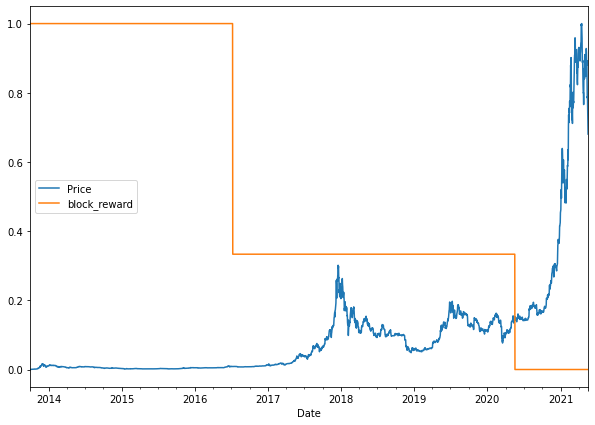

In [101]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [102]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE= 7

In [103]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()


In [104]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```


In [105]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [106]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [107]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [108]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae", optimizer="adam")

# Fit model
model_6_history = model_6.fit(X_train, y_train,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 13s - loss: 2005.8652

18/18 [==============================] - 1s 35ms/step - loss: 696.4860 - val_loss: 1395.4607
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 207.4198

18/18 [==============================] - 0s 26ms/step - loss: 197.4458 - val_loss: 1073.0144
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 152.4927

18/18 [==============================] - 0s 26ms/step - loss: 152.4927 - val_loss: 799.9411
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 162.5930

18/18 [==============================] - 1s 35ms/step - loss: 136.8998 - val_loss: 758.2099
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 135.0620

18/18 [==============================] - 1s 37ms/step - loss: 133.6031 - val_loss: 744.1751
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 134.0479 - val_loss: 781.6440
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 137.2042

18/18 [==============================] - 1s 38ms/step - loss: 134.6893 - val_loss: 719.9149
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 130.6082 - val_loss: 729.7064
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 135.9589

18/18 [==============================] - 1s 33ms/step - loss: 133.2319 - val_loss: 715.7623
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 126.3006

18/18 [==============================] - 0s 26ms/step - loss: 126.3006 - val_loss: 684.4868
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 122.7052 - val_loss: 699.4817
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 123.4779 - val_loss: 731.8315
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 122.9418 - val_loss: 686.2657
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 121.5591

18/18 [==============================] - 0s 27ms/step - loss: 118.0778 - val_loss: 654.2926
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 104.1978

18/18 [==============================] - 0s 26ms/step - loss: 119.9526 - val_loss: 641.9713
Epoch 16/100
18/18 [==============================] - 0s 4ms/step - loss: 116.0274 - val_loss: 651.6033
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9139 - val_loss: 669.5067
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 127.2179

18/18 [==============================] - 0s 27ms/step - loss: 114.2987 - val_loss: 607.8199
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3033 - val_loss: 690.4308
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 129.3710

18/18 [==============================] - 1s 43ms/step - loss: 113.7617 - val_loss: 599.8561
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 122.4361

18/18 [==============================] - 0s 26ms/step - loss: 114.2964 - val_loss: 595.7803
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8959 - val_loss: 603.3864
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 123.6983

18/18 [==============================] - 0s 26ms/step - loss: 112.5093 - val_loss: 594.2841
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 111.4226

18/18 [==============================] - 0s 27ms/step - loss: 110.3084 - val_loss: 593.6373
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 122.4576

18/18 [==============================] - 0s 26ms/step - loss: 109.2701 - val_loss: 588.4109
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 110.7002

18/18 [==============================] - 0s 27ms/step - loss: 110.7002 - val_loss: 581.7243
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 149.6226

18/18 [==============================] - 0s 26ms/step - loss: 110.4284 - val_loss: 578.8987
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0095 - val_loss: 593.0546
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9675 - val_loss: 588.7256
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 112.9053 - val_loss: 579.3195
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8484 - val_loss: 592.3415
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4645 - val_loss: 591.4463
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 135.9616

18/18 [==============================] - 0s 26ms/step - loss: 108.3264 - val_loss: 575.1778
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 117.8148

18/18 [==============================] - 0s 26ms/step - loss: 108.9151 - val_loss: 571.7115
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5734 - val_loss: 592.6513
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 111.4853

18/18 [==============================] - 0s 26ms/step - loss: 111.4853 - val_loss: 570.6378
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5352 - val_loss: 578.3885
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 112.7221 - val_loss: 616.4669
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 111.7626 - val_loss: 577.2825
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7285 - val_loss: 580.1656
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1242 - val_loss: 603.5812
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9814 - val_loss: 578.2806
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7457 - val_loss: 607.6856
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9389 - val_loss: 573.2504
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 10

18/18 [==============================] - 0s 26ms/step - loss: 110.3567 - val_loss: 568.2172
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5969 - val_loss: 598.9358
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 165.9805

18/18 [==============================] - 1s 29ms/step - loss: 110.0322 - val_loss: 566.4356
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 110.5612 - val_loss: 625.3596
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6876 - val_loss: 578.0382
Epoch 52/100
15/18 [========================>.....] - ETA: 0s - loss: 114.0732

18/18 [==============================] - 1s 39ms/step - loss: 110.4840 - val_loss: 564.4613
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 110.5060 - val_loss: 643.1650
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 115.7638 - val_loss: 614.1935
Epoch 55/100
18/18 [==============================] - 0s 8ms/step - loss: 111.8321 - val_loss: 567.8652
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 107.3380 - val_loss: 773.2338
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 127.6681 - val_loss: 781.5503
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 121.2628 - val_loss: 697.4232
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7141 - val_loss: 592.5505
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9265 - val_loss: 682.1021
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 11

18/18 [==============================] - 0s 27ms/step - loss: 106.1283 - val_loss: 562.1558
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 106.4242 - val_loss: 567.1539
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 106.7573 - val_loss: 639.2585
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8290 - val_loss: 562.9757
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 106.3957 - val_loss: 574.1917
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 106.0577 - val_loss: 569.1456
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7373 - val_loss: 573.8153
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3339 - val_loss: 594.2387
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0335 - val_loss: 591.9542
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 11

In [109]:
# Evaluate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 660.4443


660.4443359375

In [110]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 562.1556


562.1556396484375

In [111]:
# Make predictions
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8838.618, 8804.667, 9054.259, 8772.775, 8782.504, 8765.079,
       8648.724, 8563.388, 8464.917, 8541.038], dtype=float32)>

In [112]:
# Get results
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 562.15564,
 'mse': 1149112.4,
 'rmse': 1071.9666,
 'mape': 2.5223727,
 'mase': 0.98755175}

In [113]:
model_1_results

{'mae': 568.7688,
 'mse': 1160735.1,
 'rmse': 1077.3741,
 'mape': 2.5498853,
 'mase': 0.99916923}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've build so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem



### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow. we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [115]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [116]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")


Backcast: [-0.17082825  0.26910704 -0.3404805   0.51380795 -0.19284269  0.26252884
  0.12373647]
Forecast: 0.2905566990375519


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance



In [118]:
HORIZON = 1
WINDOW_SIZE = 7

In [119]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)


In [120]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [121]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
